In [82]:
import pandas as pd
from joblib import load
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [83]:
caminho = '../../../../util/data/'

In [84]:
df_categorias = load(caminho + 'df_categorias.z')
df_clientes = load(caminho + 'df_clientes.z')
df_produtos = load(caminho + 'df_produtos.z')
df_vendas = load(caminho + 'df_vendas.z')
df_unidades = load(caminho + 'df_unidades.z')
df_vendedores = load(caminho + 'df_vendedores.z')

<h3>Explorando algumas informações que podem ser consideradas</h3>

In [85]:
#adicionando uma nova coluna em df_clientes com o nome do vendedor correspondente
df_clientes['nome_vendedor'] = df_clientes['vendedor'].map(df_vendedores.set_index('codigo')['nome_completo'])

df_clientes.head()

,codigo,id_fiscal,nome,nome_fantasia,natureza_juridica,id_fiscal_2,id_fiscal_3,contribuinte_icms,vendedor,cst,nome_vendedor
0,9712,322.175.103-63,JOAO MIRANDA DA SILVA,JOAO MIRANDA DA SILVA,PF,0,ISENTO,N,9,PD,MARCIO SANTOS DE NOBREGA
1,239,17.014.825/0001-68,VERDUREIRA E SORVETERIA PALHANO LTDA,VERDUREIRA E SORVETERIA PALHANO LTDA,LT,82500016,ISENTO,S,9,PD,MARCIO SANTOS DE NOBREGA
2,8810,17.055.887/0003-80,M & C LANCHES LTDA,M & C LANCHES LTDA,LT,88700038,ISENTO,S,58,PD,CLAUDIA MARIA DAMASCENO
3,6006,17.041.611/0001-80,BAR E LANCHONETE FUNCHAL LTDA,BAR E LANCHONETE FUNCHAL LTDA,LT,61100018,ISENTO,S,79,PD,VITOR OLIVEIRA SANTOS
4,7761,17.050.253/0001-72,LANCHERIA LTDA,LANCHERIA LTDA,LT,25300017,ISENTO,S,11,PD,ADALBERTO MONTENEGRO SILVA


<h3>Criando um DataFrame com características pertinentes para análise e criação do modelo.</h3>

In [86]:
df_vendas_grouped = df_vendas.groupby('codigo_cliente').agg(
    frequencia_compras = ('documento', 'nunique'),
    valor_total_gasto = ('total', 'sum'),
    produtos_diferentes_comprados = ('codigo_produto', 'nunique'),
).reset_index()


In [87]:
df_vendas_grouped

,codigo_cliente,frequencia_compras,valor_total_gasto,produtos_diferentes_comprados
0,2,1,286.80,1
1,4,1,100.00,1
2,11,3,3700.00,4
3,22,4,2090.33,4
4,23,2,402.19,6
...,...,...,...,...
964,9704,1,960.00,1
965,9705,1,157.98,1
966,9706,1,77.68,1
967,9707,1,36.35,1


<h3>Padronizando os dados</h3>

In [88]:
from sklearn.preprocessing import RobustScaler
X = df_vendas_grouped[['frequencia_compras', 'valor_total_gasto', 'produtos_diferentes_comprados']]
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

<h3>Construindo o gráfico de "Joelho".</h3>

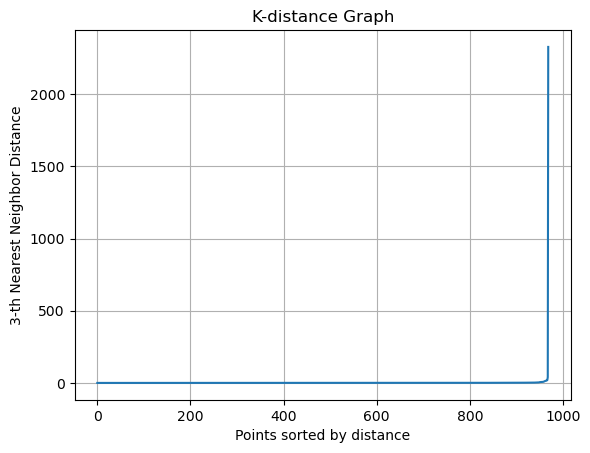

In [89]:
min_samples = 3
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, min_samples-1])
plt.plot(k_distances)
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.title('K-distance Graph')
plt.grid()
plt.show()


In [90]:
!pip install kneed

In [91]:
from kneed import KneeLocator
kneedle = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
eps_sugerido = k_distances[kneedle.knee]
print(f"Valor sugerido de eps: {eps_sugerido}")

Valor sugerido de eps: 15.31452243275982


<h3>Treinando e aplicando DBSCAN.</h3>

In [92]:
dbscan = DBSCAN(eps=5.0, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)
df_vendas_grouped['cluster'] = clusters

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
num_outliers = list(clusters).count(-1)

print(f"Número de clusters: {num_clusters}")
print(f"Número de outliers: {num_outliers}")


Número de clusters: 3
Número de outliers: 14


In [93]:
df_sem_outliers = df_vendas_grouped[df_vendas_grouped['cluster'] != -1]
print(f"Número de clientes sem outliers: {len(df_sem_outliers)}")

Número de clientes sem outliers: 955


In [94]:
print('Clientes por Cluster:\n',df_vendas_grouped['cluster'].value_counts())

Clientes por Cluster:
 cluster
 0    949
-1     14
 1      3
 2      3
Name: count, dtype: int64


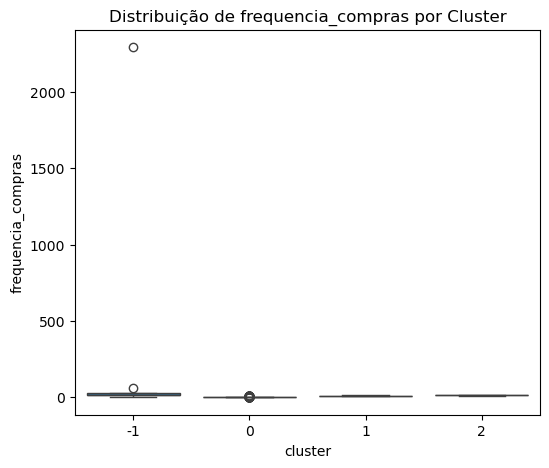

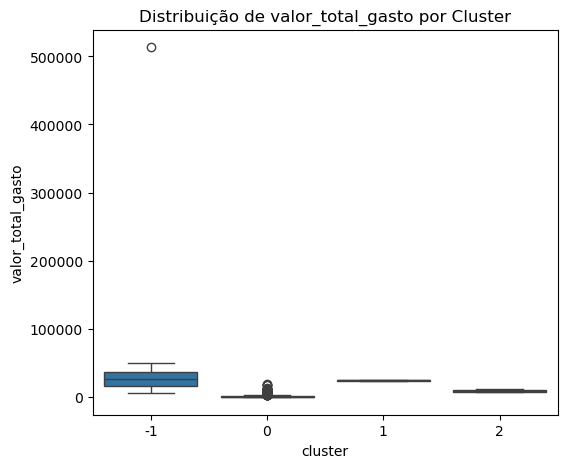

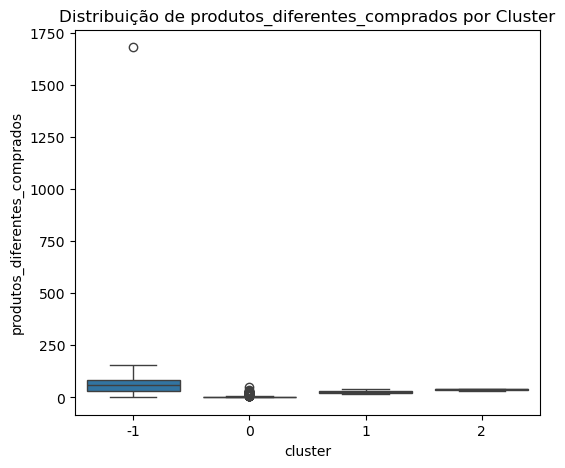

In [95]:
variaveis = ['frequencia_compras', 'valor_total_gasto', 'produtos_diferentes_comprados']

for i in variaveis:
    plt.figure(figsize=(6, 5))
    sns.boxplot(x='cluster', y=i, data=df_vendas_grouped)
    plt.title(f'Distribuição de {i} por Cluster')
    plt.show()

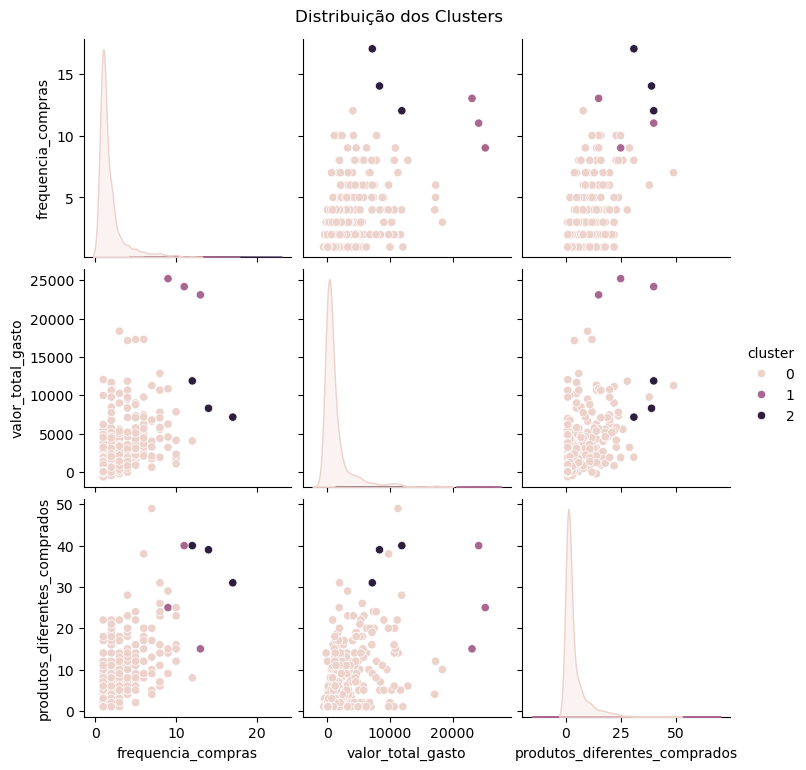

In [96]:
sns.pairplot(df_sem_outliers, hue='cluster', vars=['frequencia_compras', 'valor_total_gasto', 'produtos_diferentes_comprados'])
plt.suptitle('Distribuição dos Clusters', y=1.02)
plt.show()

In [97]:
df_sem_outliers.groupby('cluster')[['frequencia_compras', 'valor_total_gasto', 'produtos_diferentes_comprados']].mean()


,frequencia_compras,valor_total_gasto,produtos_diferentes_comprados
cluster,,,
0,1.815595,1265.099705,3.744995
1,11.000000,24168.290000,26.666667
2,14.333333,9127.350000,36.666667


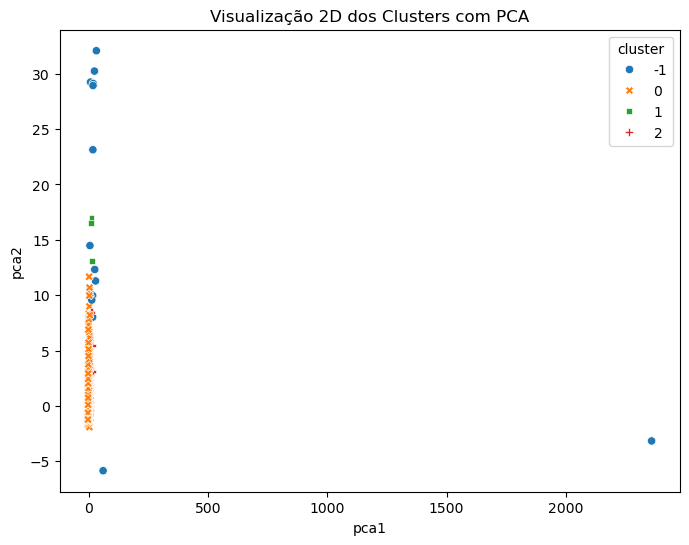

In [98]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) 
df_vendas_grouped['pca1'] = X_pca[:, 0]
df_vendas_grouped['pca2'] = X_pca[:, 1]

#gráfico
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_vendas_grouped,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette='tab10',
    style='cluster', 
    legend='full'
)
plt.title('Visualização 2D dos Clusters com PCA')
plt.show()

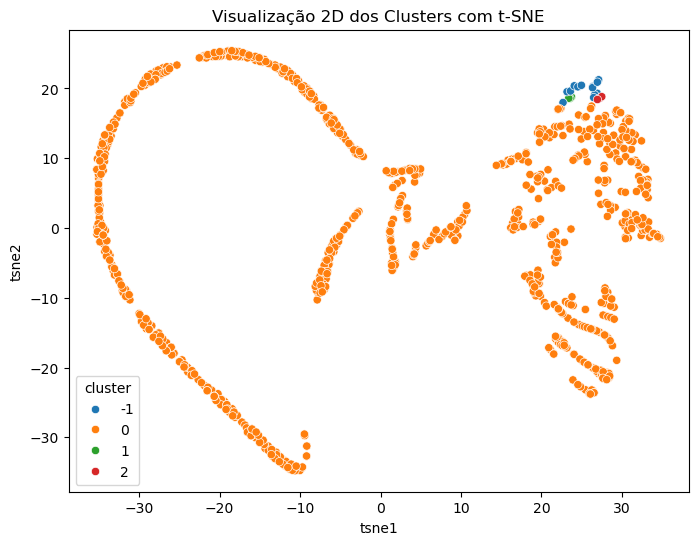

In [99]:
#t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

df_vendas_grouped['tsne1'] = X_tsne[:, 0]
df_vendas_grouped['tsne2'] = X_tsne[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_vendas_grouped,
    x='tsne1',
    y='tsne2',
    hue='cluster',
    palette='tab10',
    legend='full'
)
plt.title('Visualização 2D dos Clusters com t-SNE')
plt.show()


In [100]:
from sklearn.metrics import silhouette_score
mask = df_vendas_grouped['cluster'] != -1
X_sem_outliers = X_scaled[mask]
labels_sem_outliers = df_vendas_grouped.loc[mask, 'cluster']

In [101]:
silhouette = silhouette_score(X_sem_outliers, labels_sem_outliers)
print(f'Silhouette Score (excluindo outliers): {silhouette:.4f}')

Silhouette Score (excluindo outliers): 0.8223


<h3>Clusters testados</h3>

<p>Com a ajuda do gráfico de "joelho" e teste com diferentes tipos de <code>eps</code>, foram definidas quantidades que seriam interessantes para o teste. Foram testados de 5.0 até 15.0 <code>eps</code>, além do uso do Silhouette Score avaliando a quantidade de separação entre clusters.</p>

<h3>Justificando número de <code>eps</h3>

<p>Após o uso de 5.0 de <code>eps</code>, constatou-se tais pontos: </p>

- Favoreceu a criação de três categorias de clusters de clientes e com baixo número de outliers, mas acabou obtendo resultados agupados em grande quantidade em apenas um cluster;
- Usando eps menores, gerou possíveis overfittings e usando acima de 10 eps retornou apenas um cluster agrupado.

<h3>Insights que os resultados podem mostrar:</h3>

° <strong>Cluster 0 — Clientes Econômicos</strong>
Comportamento: baixa frequência de compra, baixo valor total e pouca variedade de produtos.

Perfil possível: compram eventualmente, talvez apenas quando há promoções ou necessidade pontual.

Estratégia: ações de reativação, incentivo de frequência com cupons ou programas de fidelidade.

° <strong>Cluster 1 — Clientes Regulares</strong>
Comportamento: frequência, gasto e variedade moderados.

Perfil possível: clientes que compram de forma previsível, com certa fidelidade.

Estratégia: manter o relacionamento, oferecer novidades e criar recompensas por continuidade.

° <strong>Cluster 2 — Clientes Premium</strong>
Comportamento: alta frequência de compras, alto gasto e grande variedade de produtos comprados.

Perfil possível: heavy users, clientes fiéis e engajados com alto valor para o negócio.

Estratégia: tratamento VIP, programas exclusivos, upselling e foco em retenção.

<h3>Observação Final:</h3>

<p>Vale destacar que é importante comparar com os demais modelos para se obter uma fiel análise de todos os modelos e usá-los da melhor maneira possível. Usando K-means, por exemplo, o mesmo conseguiu separar em 4 grupos de consumidores e bem definidos.</p>